In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [108]:
from scipy.linalg import eig
K = np.array([[1/4,1/2,0,0],[1/4,1/4,1/2,0],[1/4,0,1/4,1/2],[0,0,0,1]])
K_U = q_matrix(K,3)
l_0,phi_0 = perron_frobenius(K_U.T,[1,1,1])
K_phi_t = [doob_transform(np.linalg.matrix_power(K_U,t),[1,1,1]) for t in range(0,1000)]

In [107]:
from scipy.linalg import inv

def q_matrix(K,stable_indices_start):
    return K[:stable_indices_start,:stable_indices_start]

def fundamental_matrix(q):
    return inv(np.eye(len(q)) - q)

def dying_prob(K,stable_indices_start):
    Z = fundamental_matrix(q_matrix(K,stable_indices_start))
    return Z@K[:stable_indices_start,stable_indices_start:]

dying_prob(K,3)

array([[0.47058824],
       [0.70588235],
       [0.82352941]])

In [158]:
from scipy.linalg import norm
def perron_frobenius(T,x_0,rounds=100):
    v = x_0
    for _ in range(rounds):
        v = T@v
        v = v/norm(v)
    return np.average(T@v/v),v
def doob_transform(T,x_0):
    beta_0, phi_0 = perron_frobenius(T.T,x_0)
    return T*np.outer(1/phi_0,phi_0)/beta_0


In [16]:
from scipy.linalg import toeplitz
N = 2**5
def gen_row(N):
    res = np.zeros(N)
    for j in range(0,N):
        if (2**j >= N):
            break
        res[2**j] =  1/2**(j) if 2**(j+1) >= N else 1/2**(j+1)
    return res
def gen_markov_kernel(N,fee=2):
    I = np.eye(fee-1,N)
    r = gen_row(N+1)[1:]
    A = toeplitz([r[0]]+ [0]*(N-fee),r)
    T = np.vstack([I,A])
    return T[:N,:N]

In [649]:
dim = 1024
T = gen_markov_kernel(dim,3)
probs = np.linalg.matrix_power(T,10000).sum(axis=1)
probs[2:]

array([9.31088932e-01, 9.04840924e-01, 8.56928816e-01, ...,
       7.88078613e-21, 7.06509200e-21, 5.70666607e-21])

In [394]:
def dirichlet_series(s,ks):
    return sum([p*k**(-s) for p in ks for k in range(1,len(ks) + 1)])


In [417]:
from scipy.sparse.linalg import gmres
gmres(T - np.eye(32),[0.0001]+[0]*31)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 320)

<module 'matplotlib.pyplot' from '/home/marin/miniconda3/envs/tf310/lib/python3.10/site-packages/matplotlib/pyplot.py'>

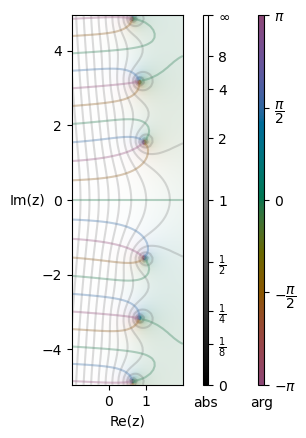

In [402]:
import cplot
f = np.vectorize(lambda s: dirichlet_series(s,probs))
cplot.plot(f,(-1,2,100),(-5,5,100))

In [88]:
K_phi_t[12]

array([[0.56839251, 0.37341626, 0.2453227 ],
       [0.51454824, 0.33804099, 0.22208258],
       [0.35062813, 0.23035162, 0.15133278]])

In [759]:
def symbol(z,precision=100,fee=2):
    return sum([z**(-fee+2**j)*2**(-j-1) for j in range(precision)])

In [760]:
from scipy.optimize import brentq
s = 0.999999999999999999999
sym_vect=np.vectorize(lambda z:symbol(z,fee=3,precision=100))
r = brentq(lambda z:sym_vect(z) - 1/s,0.5,0.9999)
r

0.9562569421511682

In [ ]:


r_powers = [r**j for j in range(1,1023)]
r_powers = [1,1] + r_powers
t = gen_markov_kernel(1024,3)

first_row = np.linalg.matrix_power(t,1000).sum(axis=1)


In [799]:
def conv(r_powers,fee):
    conv_r_powers = [0]*len(r_powers)
    for j in range(len(r_powers).bit_length() - 1):
        l_ind = max(fee-2**j,0)
        r_ind = max(2**j-fee,0)
        if r_ind > 0:
            conv_r_powers += 2**(-j-1)*np.pad(r_powers,(l_ind,r_ind))[r_ind:]
        else:
            conv_r_powers += 2**(-j-1)*np.pad(r_powers,(l_ind,r_ind))[:-l_ind]
    return np.hstack([[1]*(fee-1),conv_r_powers[fee - 1:]])

def smooth(rs,fee=3,rtol=1e-10,atol=1e-10):
    last_rs = rs
    new_rs = conv(rs,fee)
    count = 0 
    while (not np.isclose(new_rs[fee],last_rs[fee],atol=atol,rtol=rtol)):
        if count % 100 == 0:
            prog = np.abs(new_rs[fee] - last_rs[fee])
            print("Iteration: ", count,"Progress: ",prog,"\r")
        if count > 1000:
            break
        last_rs = new_rs
        new_rs = conv(new_rs,fee)
        count += 1
    return new_rs

In [2]:
#numeric solution
#parameter
fee = 15
precision = 100
money = 2**24
s = 0.999999999999

#find spectral radius
sym = np.vectorize(lambda z: symbol(z,fee=fee,precision=precision) - 1/s)
spec_r = brentq(lambda z: sym(z),0.5,s)
print("Spectral Radius: ",spec_r)

#initial guess for eigenvector
#v_init = [1]*(fee-1) + [spec_r**j for j in range(1,money - fee)]
v_init = [1]*(fee-1) + [spec_r]*(money - fee - 1)

#update v by smoothing
v = smooth(v_init,fee=fee,rtol=1e-9,atol=1e-9)

NameError: name 'brentq' is not defined

In [828]:
v[2**10:2**10+15]

array([0.99999741, 0.9999974 , 0.9999974 , 0.9999974 , 0.9999974 ,
       0.9999974 , 0.99999739, 0.99999739, 0.99999739, 0.99999739,
       0.99999739, 0.99999738, 0.99999738, 0.99999738, 0.99999738])

In [833]:
v[-30:]

array([0.93688146, 0.93657697, 0.93604044, 0.93580693, 0.93564773,
       0.93493965, 0.93387595, 0.93313059, 0.93111447, 0.92916702,
       0.92889708, 0.9288161 , 0.92780013, 0.91397235, 0.91378348,
       0.91334118, 0.91280136, 0.91249509, 0.91212352, 0.91112691,
       0.90925238, 0.90827001, 0.90668249, 0.90542655, 0.90351968,
       0.90306994, 0.89875611, 0.89154025, 0.89039007, 0.86272611])

In [ ]:
# calculate green with monte carlo

import numpy as np

s = 2.51154714
fee = 15
population = 100_000
iterations = 2000
log_prob_sample_cutoff = 100

rng = np.random.default_rng()

# Jump sizes and probabilities
jumps = 2 ** np.arange(log_prob_sample_cutoff)
p = (1-1/s)*s ** (-np.arange(0, log_prob_sample_cutoff))
p[-1] += 1 - p.sum()   # normalize tail


In [171]:
iterations*population

20000000000

In [183]:
init_wealth = 10**2
x = np.full(population, init_wealth, dtype=np.int32)

for round in range(iterations):
    active = x >= fee
    n_active = active.sum()

    if n_active == 0:
        break

    # Sample jumps only for active states
    sampled_jumps = rng.choice(jumps, size=n_active, p=p)

    # Apply transition
    x[active] = x[active] - fee + sampled_jumps
    
    print((round // 100) * 100, end="\r")


In [188]:
result

{np.int32(61245): np.float64(1e-05),
 np.int32(63241): np.float64(1e-05),
 np.int32(64661): np.float64(1e-05),
 np.int32(64770): np.float64(1e-05),
 np.int32(65592): np.float64(1e-05),
 np.int32(65771): np.float64(1e-05),
 np.int32(65919): np.float64(1e-05),
 np.int32(66001): np.float64(1e-05),
 np.int32(66094): np.float64(1e-05),
 np.int32(66661): np.float64(1e-05),
 np.int32(66719): np.float64(1e-05),
 np.int32(66976): np.float64(1e-05),
 np.int32(67191): np.float64(1e-05),
 np.int32(67200): np.float64(1e-05),
 np.int32(67272): np.float64(1e-05),
 np.int32(67725): np.float64(1e-05),
 np.int32(67773): np.float64(1e-05),
 np.int32(67852): np.float64(1e-05),
 np.int32(67961): np.float64(1e-05),
 np.int32(67984): np.float64(1e-05),
 np.int32(68031): np.float64(1e-05),
 np.int32(68386): np.float64(1e-05),
 np.int32(68463): np.float64(1e-05),
 np.int32(68547): np.float64(1e-05),
 np.int32(68656): np.float64(1e-05),
 np.int32(68670): np.float64(1e-05),
 np.int32(68715): np.float64(1e-05),
 

In [187]:
values, counts = np.unique(x, return_counts=True)
probs = counts / population
result = dict(zip(values, probs))


In [189]:
pp = probs[:14]

In [190]:
sum(probs[:14])

np.float64(0.00014000000000000001)

In [191]:
result

{np.int32(61245): np.float64(1e-05),
 np.int32(63241): np.float64(1e-05),
 np.int32(64661): np.float64(1e-05),
 np.int32(64770): np.float64(1e-05),
 np.int32(65592): np.float64(1e-05),
 np.int32(65771): np.float64(1e-05),
 np.int32(65919): np.float64(1e-05),
 np.int32(66001): np.float64(1e-05),
 np.int32(66094): np.float64(1e-05),
 np.int32(66661): np.float64(1e-05),
 np.int32(66719): np.float64(1e-05),
 np.int32(66976): np.float64(1e-05),
 np.int32(67191): np.float64(1e-05),
 np.int32(67200): np.float64(1e-05),
 np.int32(67272): np.float64(1e-05),
 np.int32(67725): np.float64(1e-05),
 np.int32(67773): np.float64(1e-05),
 np.int32(67852): np.float64(1e-05),
 np.int32(67961): np.float64(1e-05),
 np.int32(67984): np.float64(1e-05),
 np.int32(68031): np.float64(1e-05),
 np.int32(68386): np.float64(1e-05),
 np.int32(68463): np.float64(1e-05),
 np.int32(68547): np.float64(1e-05),
 np.int32(68656): np.float64(1e-05),
 np.int32(68670): np.float64(1e-05),
 np.int32(68715): np.float64(1e-05),
 

In [616]:
import numpy as np
from scipy.sparse import csr_matrix, identity
from scipy.sparse.linalg import spsolve

# ----------------------------
# Parameters
# ----------------------------
s = 2.51154714
fee = 15
M = 400        # truncation level
absorbing = np.arange(fee)          # 0 .. 14
transient = np.arange(fee, M + 1)   # 15 .. M

na = len(absorbing)
nt = len(transient)

# ----------------------------
# Build Q (transient -> transient)
# and R (transient -> absorbing)
# ----------------------------
Q_rows, Q_cols, Q_data = [], [], []
R_rows, R_cols, R_data = [], [], []

for i, x in enumerate(transient):
    j = 0
    while True:
        y = x - fee + (1 << j)
        p = (1-1/s) * s ** (- j )

        if y > M:
            break

        if y < fee:
            # absorption
            R_rows.append(i)
            R_cols.append(y)
            R_data.append(p)
        else:
            # transient transition
            Q_rows.append(i)
            Q_cols.append(y - fee)
            Q_data.append(p)

        j += 1

Q = csr_matrix((Q_data, (Q_rows, Q_cols)), shape=(nt, nt))
R = csr_matrix((R_data, (R_rows, R_cols)), shape=(nt, na))

# ----------------------------
# Fundamental matrix N = (I - Q)^(-1)
# Solve N @ R by columns (memory efficient)
# ----------------------------
I = identity(nt, format="csr")

# We want B = N @ R
# Solve (I - Q) X = R for X
from scipy.sparse.linalg import splu



# Solve adjoint system

rhs = np.zeros(nt)
rhs[0] = 1.0

#z = splu((I - Q).T).solve(rhs)

# Absorption probabilities

from scipy.sparse.linalg import gmres

z, info = gmres((I - Q).T, rhs, rtol=1e-10)
absorption_probs = z @ R.toarray()

absorption_probs


array([0.00000000e+00, 6.01964594e-01, 2.48904210e-01, 3.91487212e-03,
       9.78300618e-02, 3.45577988e-03, 6.05546276e-04, 8.72346912e-04,
       3.87695251e-02, 1.24658258e-03, 5.27580135e-04, 7.03866522e-04,
       5.05274246e-04, 2.24505555e-04, 2.08299148e-04])

In [ ]:
Absorption probabilities starting from x = fee:
  Absorb at state  0: 0.00000000
  Absorb at state  1: 0.50063000
  Absorb at state  2: 0.26656029
  Absorb at state  3: 0.00913690
  Absorb at state  4: 0.13015420
  Absorb at state  5: 0.00915688
  Absorb at state  6: 0.00235007
  Absorb at state  7: 0.00296324
  Absorb at state  8: 0.06514365
  Absorb at state  9: 0.00401144
  Absorb at state 10: 0.00206071
  Absorb at state 11: 0.00272348
  Absorb at state 12: 0.00230192
  Absorb at state 13: 0.00134678
  Absorb at state 14: 0.00135305

Total absorption probability: 0.99989262

In [162]:

print("Absorption probabilities starting from x = fee:")
for k, p in enumerate(absorption_probs):
    print(f"  Absorb at state {k:2d}: {p:.8f}")

print(f"\nTotal absorption probability: {absorption_probs.sum():.8f}")

Absorption probabilities starting from x = fee:
  Absorb at state  0: 0.00000000
  Absorb at state  1: 0.50063000
  Absorb at state  2: 0.26656029
  Absorb at state  3: 0.00913690
  Absorb at state  4: 0.13015420
  Absorb at state  5: 0.00915688
  Absorb at state  6: 0.00235007
  Absorb at state  7: 0.00296324
  Absorb at state  8: 0.06514365
  Absorb at state  9: 0.00401144
  Absorb at state 10: 0.00206071
  Absorb at state 11: 0.00272348
  Absorb at state 12: 0.00230192
  Absorb at state 13: 0.00134678
  Absorb at state 14: 0.00135305

Total absorption probability: 0.99989262


In [52]:
green = absorption_probs[1:]
green

array([0.50063   , 0.26656029, 0.0091369 , 0.1301542 , 0.00915688,
       0.00235007, 0.00296324, 0.06514365, 0.00401144, 0.00206071,
       0.00272348, 0.00230192, 0.00134678, 0.00135305])

In [4]:
from scipy.linalg import toeplitz
tau = toeplitz([1/2]+[0]*13,[1/2,1/4,0,0,0,1/8,0,0,0,0,0,0,0,1/16])
green_2 = tau[0]
green_2 += 1/32*(tau@g[:14])
green_2

array([5.16186338e-01, 2.50047275e-01, 2.93829552e-04, 6.96189933e-05,
       6.87807262e-05, 1.25100915e-01, 1.08332138e-03, 1.08259960e-03,
       1.11573266e-03, 1.14218856e-04, 1.16977975e-03, 2.11943011e-03,
       2.24624710e-03, 6.66852542e-02])

In [5]:
green = [np.float64(0.50072375),
  np.float64(0.266557),
  np.float64(0.009127),
  np.float64(0.1302335),
  np.float64(0.0091005),
  np.float64(0.002307),
  np.float64(0.00294475),
  np.float64(0.06507775),
  np.float64(0.00401975),
  np.float64(0.002062),
  np.float64(0.00275725),
  np.float64(0.002348),
  np.float64(0.001374),
  np.float64(0.001366)]

In [94]:
poly_coeffs = [1] + [-g for g in green]
roots = np.roots(poly_coeffs)
roots
comp = np.polynomial.polynomial.polycompanion( np.hstack([(-1)*np.array(green),[1]]))
comp = comp.T


In [ ]:
poly_coeffs = [1] + [-g for g in green]
roots = np.roots(poly_coeffs)
roots
comp = np.polynomial.polynomial.polycompanion( np.hstack([(-1)*np.array(green),[1]]))
comp = comp.T


In [586]:
roots/roots[0]*a

array([ 1.        +0.j        ,  0.54979196+0.32362687j,
        0.54979196-0.32362687j,  0.43630959+0.4181632j ,
        0.43630959-0.4181632j ,  0.06172789+0.69121927j,
        0.06172789-0.69121927j, -0.73215442+0.j        ,
       -0.44179653+0.46825217j, -0.44179653-0.46825217j,
       -0.45012585+0.23042706j, -0.45012585-0.23042706j,
       -0.03950334+0.49212138j, -0.03950334-0.49212138j])

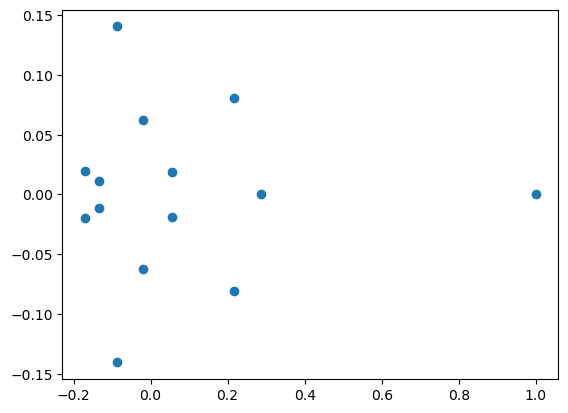

In [153]:
import matplotlib.pyplot as plt
plt.scatter(np.real(roots**(4)),np.imag(roots**(4)))
plt.show()

In [583]:
comp

array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0. 

In [148]:
np.linalg.matrix_power(comp,10**4)/pp

array([[0.92837597, 0.92620936, 0.90720404, 0.90755873, 0.94409532,
        0.92612425, 0.90508165, 0.91823286, 0.91492978, 0.91847952,
        0.92301055, 0.94558919, 0.91737805, 0.90499146],
       [0.9283681 , 0.92620151, 0.90719634, 0.90755104, 0.94408731,
        0.9261164 , 0.90507397, 0.91822507, 0.91492203, 0.91847174,
        0.92300272, 0.94558118, 0.91737027, 0.90498379],
       [0.92836023, 0.92619365, 0.90718865, 0.90754334, 0.94407931,
        0.92610855, 0.9050663 , 0.91821729, 0.91491427, 0.91846395,
        0.9229949 , 0.94557316, 0.91736249, 0.90497611],
       [0.92835236, 0.9261858 , 0.90718096, 0.90753565, 0.9440713 ,
        0.92610069, 0.90505862, 0.9182095 , 0.91490651, 0.91845616,
        0.92298707, 0.94556514, 0.91735471, 0.90496844],
       [0.92834449, 0.92617795, 0.90717327, 0.90752795, 0.9440633 ,
        0.92609284, 0.90505095, 0.91820172, 0.91489875, 0.91844837,
        0.92297924, 0.94555712, 0.91734693, 0.90496077],
       [0.92833662, 0.92617009, 0.9

In [124]:
pp

array([0.038525, 0.061   , 0.061925, 0.068975, 0.075825, 0.072275,
       0.074725, 0.0768  , 0.075225, 0.0761  , 0.078975, 0.079125,
       0.0789  , 0.079775])

In [67]:
[np.abs(r) for r in roots]

[np.float64(1.1373438981169048),
 np.float64(1.0807234596163107),
 np.float64(1.0807234596163107),
 np.float64(1.0593788521159007),
 np.float64(1.0593788521159007),
 np.float64(1.0389931046569065),
 np.float64(1.0389931046569065),
 np.float64(1.0558258520205697),
 np.float64(1.0558258520205697),
 np.float64(1.0321363256488094),
 np.float64(1.0321363256488094),
 np.float64(1.0223178091121514),
 np.float64(1.0223178091121514),
 np.float64(1.0000084789933774)]

In [72]:
coeffs = np.linalg.inv(comp)

In [110]:
sum((np.exp(10**4*np.log(roots)))@coeffs)

np.complex128(0.6314300442111065+0j)

In [218]:
def stable_coeffs(i,j,roots):
    l = len(roots)
    if (i >= l or j >= l):
        return -1
    else:
        res = roots[j]**(l - 2)
        for k in range(l):
            if k == j:
                continue
            else:
                res *= roots[k] - roots[j]
        return res

In [212]:
l = len(roots)
stable = np.array([[stable_coeffs(i,j,roots) for j in range(l)] for i in range(l)])
stable

array([[-2.33325611e+00+0.00000000e+00j,  2.19215377e-04-2.07723053e-02j,
         2.19215377e-04+2.07723053e-02j, -1.42382056e-02+1.30002302e-03j,
        -1.42382056e-02-1.30002302e-03j,  3.96691685e-02-4.35246007e-02j,
         3.96691685e-02+4.35246007e-02j, -1.09907711e-01-1.38777878e-17j,
        -1.76231715e-02-2.92026657e-02j, -1.76231715e-02+2.92026657e-02j,
        -6.94260504e-03+3.57781512e-04j, -6.94260504e-03-3.57781512e-04j,
        -6.30455836e-03-1.66620845e-03j, -6.30455836e-03+1.66620845e-03j],
       [-2.33325611e+00+0.00000000e+00j,  2.19215377e-04-2.07723053e-02j,
         2.19215377e-04+2.07723053e-02j, -1.42382056e-02+1.30002302e-03j,
        -1.42382056e-02-1.30002302e-03j,  3.96691685e-02-4.35246007e-02j,
         3.96691685e-02+4.35246007e-02j, -1.09907711e-01-1.38777878e-17j,
        -1.76231715e-02-2.92026657e-02j, -1.76231715e-02+2.92026657e-02j,
        -6.94260504e-03+3.57781512e-04j, -6.94260504e-03-3.57781512e-04j,
        -6.30455836e-03-1.66620845e-0

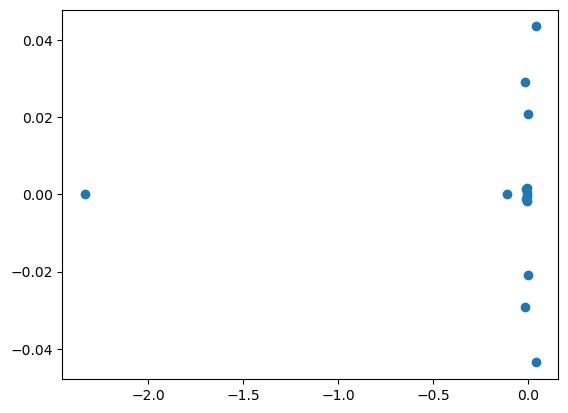

In [213]:
plt.scatter(np.real(stable[0]),np.imag(stable[0]))
plt.show()

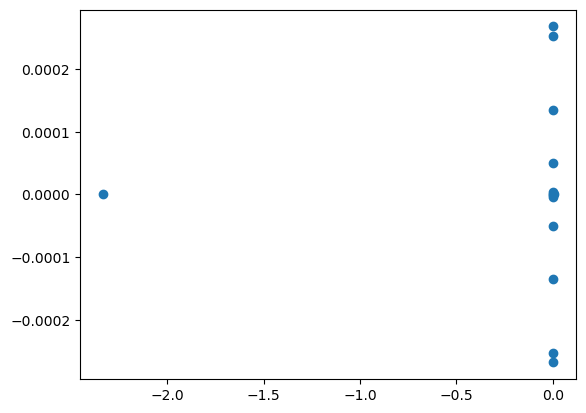

In [219]:
mod_roots = roots.copy()
mod_roots[0] = 1
mod_roots = [stable_coeffs(0,j,mod_roots) for j in range(len(mod_roots))]
plt.scatter(np.real(mod_roots),np.imag(mod_roots))

plt.show()

In [566]:
def G(z):
    res = 0
    for j in range(120):
        res += 2**(-j-1)*(z)**(2**j-fee)
    return res


In [579]:
G(0.9999999994975306)

0.9999999994974814

In [574]:
from scipy.optimize import brentq
fee = 15
brentq(lambda z: G(z) - z, 0.999999999,0.999999999999,rtol=1e-15)

0.9999999994975306

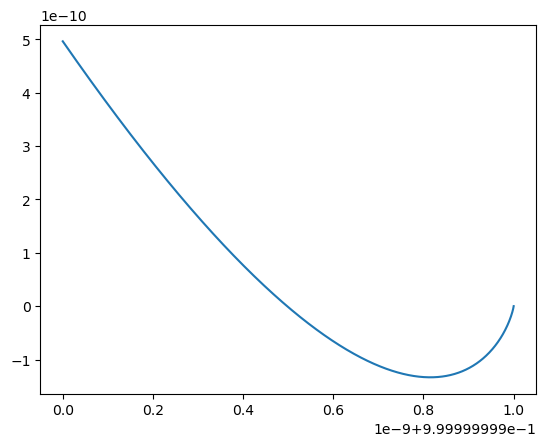

In [567]:
x = np.linspace(0.999999999,1,1000)
g_vect = np.vectorize(lambda z:G(z) - z)
fee = 15
plt.plot(x,g_vect(x))


In [494]:
g_vect(0.5 + 5.5511152e-17)

array(-0.48413086)

In [257]:
from scipy.optimize import minimize_scalar
minimize_scalar(g_vect,(0.497,0.498,1.2))

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: -0.4941733054953258
       x: 0.6959810510852767
     nit: 9
    nfev: 12

In [727]:
r = Decimal(
    0.9999999994975306
)

Decimal(1) - r**(10**9)

Decimal('0.394965259053454444832593454258401859802590868554459233210313')

In [587]:
a = 0.9999999994975306

In [593]:
roots_rescaled = np.array(roots/roots[0],dtype=np.complex128)*a

In [595]:


np.linalg.matrix_power(root)

np.complex128(0.9999999994975306+0j)

In [601]:
poly_coeffs = np.poly(roots_rescaled)
comp = np.polynomial.polynomial.polycompanion(np.flip(poly_coeffs))
comp = comp.T
comp


array([[0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0. 

In [604]:
np.linalg.matrix_power(comp,10**9).sum(axis=1)

array([0.60503022, 0.60503022, 0.60503022, 0.60503022, 0.60503022,
       0.60503022, 0.60503022, 0.60503022, 0.60503022, 0.60503021,
       0.60503021, 0.60503021, 0.60503021, 0.60503021])

In [622]:
np.poly([2,2])

array([ 1., -4.,  4.])

In [706]:
import numpy as np
from scipy.optimize import root_scalar

def moment_X(t, cutoff=200):
    j = np.arange(cutoff)
    return np.sum(np.exp(t * (2.0 ** j)) * (2.0 ** (-j - 1)))

def moment_X_prim(t, cutoff=200):
    j = np.arange(cutoff)
    return 0.5 * np.sum(np.exp(t * (2.0 ** j)))

def g(t, fee=15):
    return np.exp(t * fee) - moment_X(t)

def g_prim(t, fee=15):
    return fee * np.exp(t * fee) - moment_X_prim(t)

fee = 15

r = root_scalar(
    g,
    fprime=g_prim,
    x0=-5e-3,
    method="newton",
    rtol=1e-12
)

print(r.root)


-3.0454602925216e-09


In [701]:
g(Decimal(-2e-9))

Decimal('7.30215881601097487150939411922909469301E-12')

In [695]:
1 - np.exp(r.root*initial_capital)

np.float64(0.8660312518797204)

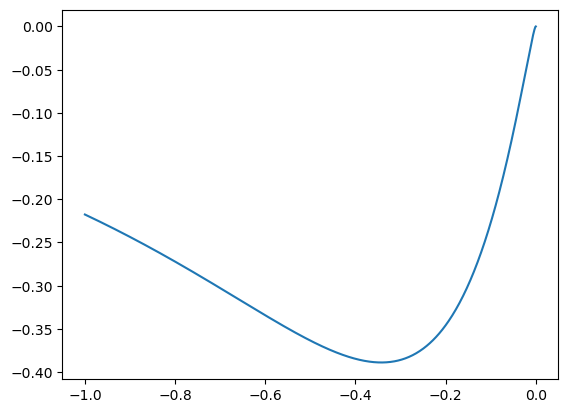

In [655]:
t = np.linspace(-,0,1000)
plt.plot(t,g(t,6))

In [724]:
from decimal import Decimal, getcontext

# ------------------------------------------------------------------
# High precision configuration
# ------------------------------------------------------------------
getcontext().prec = 60


# ------------------------------------------------------------------
# Claim size MGF:  P(X = 2^j) = 2^{-j-1}
# ------------------------------------------------------------------
def moment_X(t, cutoff=200):
    """
    M_X(t) = sum_{j>=0} 2^{-j-1} * exp(t * 2^j)
    """
    res = Decimal(0)
    half = Decimal(1) / Decimal(2)
    two = Decimal(2)

    for j in range(cutoff):
        weight = half * (two ** (-j))
        res += weight * (t * (two ** j)).exp()

    return res


def moment_X_prim(t, cutoff=200):
    """
    M_X'(t) = 1/2 * sum_{j>=0} exp(t * 2^j)
    """
    res = Decimal(0)
    half = Decimal(1) / Decimal(2)
    two = Decimal(2)

    for j in range(cutoff):
        res += half * (t * (two ** j)).exp()

    return res


# ------------------------------------------------------------------
# Lundberg equation g(t) = exp(c t) - M_X(t)
# ------------------------------------------------------------------
def g(t, fee=15, cutoff=200):
    return (t * Decimal(fee)).exp() - moment_X(t, cutoff)


def g_prim(t, fee=15, cutoff=200):
    return Decimal(fee) * (t * Decimal(fee)).exp() - moment_X_prim(t, cutoff)


# ------------------------------------------------------------------
# Pure Decimal Newton solver
# ------------------------------------------------------------------
def newton_decimal(
    f,
    fprime,
    x0,
    tol=Decimal("1e-59"),
    max_iter=200
):
    x = Decimal(x0)
    history = []

    for n in range(max_iter):
        fx = f(x)
        fpx = fprime(x)

        history.append((n, x, fx))

        if abs(fx) < tol:
            return x, history

        if fpx == 0:
            raise ZeroDivisionError("Derivative vanished during Newton iteration")

        x_new = x - fx / fpx

        # Safeguard against divergence
        if abs(x_new - x) > Decimal(1):
            raise ArithmeticError("Newton step exploded")

        x = x_new

    raise RuntimeError("Newton method did not converge")


# ------------------------------------------------------------------
# Solve for the (truncated) adjustment coefficient
# ------------------------------------------------------------------
if __name__ == "__main__":
    fee = 15
    cutoff = 10000
    x0 = Decimal("-0.005")

    root, history = newton_decimal(
        lambda t: g(t, fee=fee, cutoff=cutoff),
        lambda t: g_prim(t, fee=fee, cutoff=cutoff),
        x0
    )

    print("Adjustment coefficient (truncated):")
    print(root)

    print("\nNewton iteration history (last 5 steps):")
    for h in history[-5:]:
        print(h)

print(Decimal(1) - Decimal.exp(root*Decimal(1e9)))

Adjustment coefficient (truncated):
-2.01014859555154274559711195261355496515776656610053084340916E-9

Newton iteration history (last 5 steps):
(10, Decimal('-2.01015350728617432163050443852650423993369694347086401101050E-9'), Decimal('-3.543074632999289523624088984766903118692883501E-15'))
(11, Decimal('-2.01014859555754354748610404799224681710715603483604144841259E-9'), Decimal('-4.328666870220299914823116866576107635901E-21'))
(12, Decimal('-2.01014859555154274559712090955729386871221873252008324802585E-9'), Decimal('-6.461074092794827323434559360E-33'))
(13, Decimal('-2.01014859555154274559711195261355496515776656612048514919890E-9'), Decimal('-1.4394E-56'))
(14, Decimal('-2.01014859555154274559711195261355496515776656610053084340916E-9'), Decimal('-1E-60'))
0.866031233973003488805638245666965605560275349296767269051546


Decimal('2.71828182845904523536028747135266249775724709369995957496697')